### Ефимова Василиса (4ИВТ)
#### Практическая работа № 2
#### Предсказание дефолта по кредиту

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier # классификатор дерева решений

from sklearn.model_selection import KFold # k-fold кросс-валидация

from sklearn.metrics import roc_curve, precision_recall_curve, auc # метрики качества
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score # метрики качества
from sklearn.metrics import average_precision_score # метрики качества

In [ ]:
%%capture
!wget https://www.dropbox.com/s/io67uppgq66plbp/training_data.csv
!wget https://www.dropbox.com/s/2ga9maqxbsf8xhg/test_data.csv

In [ ]:
training_data = pd.read_csv('training_data.csv')
training_data.sample(10, random_state=123)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
11872,0,0.336531,66,0,0.517186,10589.0,9,0,4,0,0.0
40828,0,0.017424,40,0,0.376570,6051.0,11,0,2,0,1.0
36400,0,0.079785,42,0,0.786468,6916.0,9,0,3,0,1.0
5166,0,0.000349,50,1,0.340891,11070.0,7,0,2,0,0.0
30273,0,1.000714,31,0,0.594670,1800.0,6,0,0,0,1.0
31249,0,0.071795,42,0,1586.000000,NaN,4,0,2,0,NaN
21872,0,0.274562,52,0,0.226425,14538.0,17,0,2,0,1.0
47728,0,0.006529,82,0,7.000000,NaN,6,0,0,0,0.0
7261,0,0.018731,64,0,0.076228,7083.0,13,0,0,0,0.0
6456,0,0.393872,36,2,0.276135,2400.0,5,0,0,1,1.0


In [ ]:
# общая статистика по датам
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,50000.0,0.066860,0.249782,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,50000.0,7.927880,332.393142,0.0,0.030096,0.154426,0.555651,50708.0
age,50000.0,52.240520,14.766593,21.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,50000.0,0.428220,4.269296,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,50000.0,352.441921,2006.426016,0.0,0.176304,0.366811,0.862599,329664.0
MonthlyIncome,40147.0,6642.232222,18122.708690,0.0,3400.000000,5400.000000,8250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,50000.0,8.476040,5.172756,0.0,5.000000,8.000000,11.000000,57.0
NumberOfTimes90DaysLate,50000.0,0.269920,4.243110,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,50000.0,1.017500,1.120151,0.0,0.000000,1.000000,2.000000,32.0
NumberOfTime60-89DaysPastDueNotWorse,50000.0,0.246040,4.231055,0.0,0.000000,0.000000,0.000000,98.0


In [ ]:
# проверка данных на наличие пропусков и типов переменных
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         40147 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    48667 non-null  float64
dtypes: float64(4), 

In [ ]:
# генерация средних значений для заполнения пропусков в данных
train_mean = training_data.mean()
train_mean

SeriousDlqin2yrs                           0.066860
RevolvingUtilizationOfUnsecuredLines       7.927880
age                                       52.240520
NumberOfTime30-59DaysPastDueNotWorse       0.428220
DebtRatio                                352.441921
MonthlyIncome                           6642.232222
NumberOfOpenCreditLinesAndLoans            8.476040
NumberOfTimes90DaysLate                    0.269920
NumberRealEstateLoansOrLines               1.017500
NumberOfTime60-89DaysPastDueNotWorse       0.246040
NumberOfDependents                         0.756180
dtype: float64

In [ ]:
# заполнение пропусков данных
training_data.fillna(train_mean, inplace=True)
# проверка
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,50000.0,0.066860,0.249782,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,50000.0,7.927880,332.393142,0.0,0.030096,0.154426,0.555651,50708.0
age,50000.0,52.240520,14.766593,21.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,50000.0,0.428220,4.269296,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,50000.0,352.441921,2006.426016,0.0,0.176304,0.366811,0.862599,329664.0
MonthlyIncome,50000.0,6642.232222,16239.161109,0.0,3910.000000,6600.000000,7416.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,50000.0,8.476040,5.172756,0.0,5.000000,8.000000,11.000000,57.0
NumberOfTimes90DaysLate,50000.0,0.269920,4.243110,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,50000.0,1.017500,1.120151,0.0,0.000000,1.000000,2.000000,32.0
NumberOfTime60-89DaysPastDueNotWorse,50000.0,0.246040,4.231055,0.0,0.000000,0.000000,0.000000,98.0


In [ ]:
# целевая переменная - наличие дефолта
target_variable_name = 'SeriousDlqin2yrs'

In [ ]:
# подсчет "хороших" и "плохих" заемщиков
training_data[target_variable_name].value_counts()

0    46657
1     3343
Name: SeriousDlqin2yrs, dtype: int64

In [ ]:
# столбец с целевой переменной
training_values = training_data[target_variable_name]
# проверка размерности
training_values.shape

(50000,)

In [ ]:
# для построения модели предсказания целевой переенной необходимо отделить входные данные от целевой переменной
training_points = training_data.drop(target_variable_name, axis=1)
training_data.shape
training_points.shape

(50000, 10)

## Обучение модели на обучающей выборке

In [ ]:
from sklearn import linear_model, ensemble

In [ ]:
# создание модели логистической регрессии
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# обучение модели логистической регрессии
logistic_regression_model.fit(training_points, training_values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# создание модели случайного леса
random_forest_model = ensemble.RandomForestClassifier(n_estimators=100)
random_forest_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# обучение модели случайного леса
random_forest_model.fit(training_points, training_values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Предобработка данных для тестирования

In [ ]:
test_data = pd.read_csv('test_data.csv')
test_data.fillna(train_mean, inplace=True)
test_values = test_data[target_variable_name]
test_points = test_data.drop(target_variable_name, axis=1)
test_points.shape

(37500, 10)

## Валидация модели на тестовой выборке

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# прогноз модели логистической регрессии
test_predictions_logistic_regression = logistic_regression_model.predict(test_points)
pd.value_counts(test_predictions_logistic_regression)

0    37436
1       64
dtype: int64

In [ ]:
# прогноз модели решающего леса
test_predictions_random_forest = random_forest_model.predict(test_points)
pd.value_counts(test_predictions_random_forest)

0    36644
1      856
dtype: int64

In [ ]:
# точность моделей
print(accuracy_score(test_values, test_predictions_logistic_regression))
print(accuracy_score(test_values, test_predictions_random_forest))

0.9324533333333334
0.9342133333333333


In [ ]:
# сравнение значения точности для моделей с точностью для константного классификатора
print(accuracy_score(test_values, np.zeros_like(test_values)))
# для логистической регрессии точность очень близка к точности константного классификатора

0.9326133333333333


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# таблица сопряженности для логистической регрессии
logistic_regression_confusion_matrix = confusion_matrix(test_values, test_predictions_logistic_regression)
logistic_regression_confusion_matrix = pd.DataFrame(logistic_regression_confusion_matrix)
logistic_regression_confusion_matrix

,0,1
0,34938,35
1,2498,29


In [ ]:
# таблица сопряженности для случайного леса
random_forest_confusion_matrix = confusion_matrix(test_values, test_predictions_random_forest)
random_forest_confusion_matrix = pd.DataFrame(random_forest_confusion_matrix)
random_forest_confusion_matrix

,0,1
0,34575,398
1,2069,458


In [ ]:
# модель логистической регрессии
# метки вероятности принадлежности к классам
test_probabilities = logistic_regression_model.predict_proba(test_points)
test_probabilities[:5, :]
test_probabilities = test_probabilities[:, 1]

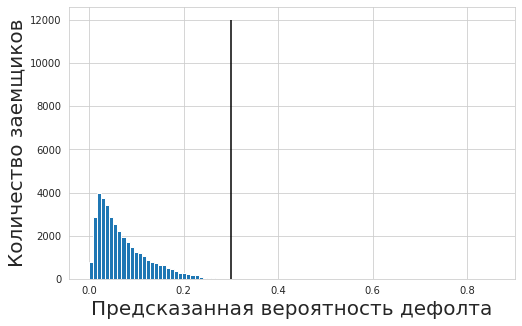

In [ ]:
# модель логистической регрессии
# распределение предсказанной классификатором вероятности дефолта, метки 1
plt.figure(figsize=(8, 5))

plt.hist(test_probabilities, bins=100)
plt.vlines(0.3, 0, 12000)

plt.xlabel('Предсказанная вероятность дефолта', fontsize=20)
plt.ylabel('Количество заемщиков', fontsize=20);

Игноририруется метка `1`, т.к. меток `1` в обучающей выборке сильно меньше, чем меток `0`

In [ ]:
# модель случайного леса
# метки вероятности принадлежности к классам
test_probabilities = random_forest_model.predict_proba(test_points)
test_probabilities[:5, :]
test_probabilities = test_probabilities[:, 1]

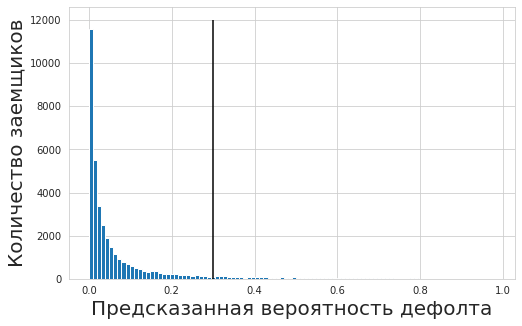

In [ ]:
# модель случайного леса
# распределение предсказанной классификатором вероятности дефолта, метки 1
plt.figure(figsize=(8, 5))

plt.hist(test_probabilities, bins=100)
plt.vlines(0.3, 0, 12000)

plt.xlabel('Предсказанная вероятность дефолта', fontsize=20)
plt.ylabel('Количество заемщиков', fontsize=20);

In [ ]:
# влияние порога на матрицу сопряженности
# низкий порог
higher_thershold = 0.3
alternative_test_predictions = test_probabilities > higher_thershold
alternative_confusion_matrix = pd.DataFrame(confusion_matrix(test_values, alternative_test_predictions))
alternative_confusion_matrix

,0,1
0,33584,1389
1,1555,972


In [ ]:
# влияние порога на матрицу сопряженности
# высокий порог
higher_thershold = 0.7
alternative_test_predictions = test_probabilities > higher_thershold
alternative_confusion_matrix = pd.DataFrame(confusion_matrix(test_values, alternative_test_predictions))
alternative_confusion_matrix

,0,1
0,34918,55
1,2402,125


In [ ]:
# доли истинно позитивных срабатываний (TPR) от доли ложно позитивных срабатываний (FPR) при изменении порога классификации
false_positive_rates, true_positive_rates, threshold = roc_curve(test_values, test_probabilities)

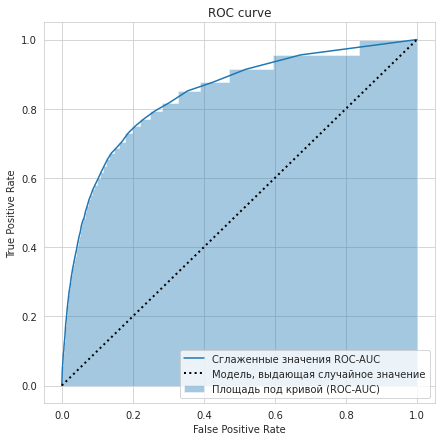

In [ ]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_value = roc_auc_score(test_values, test_probabilities)

print("ROC-AUC на тестовой выборке:", roc_auc_value) 

ROC-AUC на тестовой выборке: 0.8406607715957397


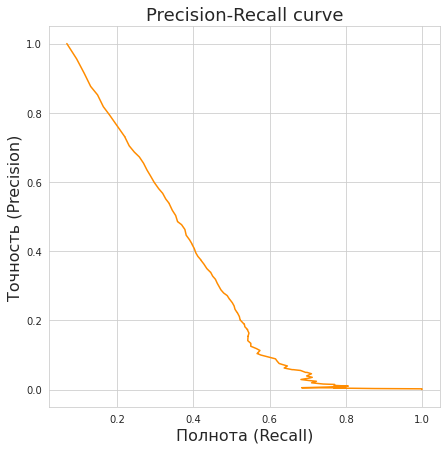

In [ ]:
precision, recall, _ = precision_recall_curve(test_values, test_probabilities)
plt.figure(figsize=(7, 7))

plt.plot(precision, recall, color='darkorange')

plt.title('Precision-Recall curve', fontsize=18)
plt.xlabel('Полнота (Recall)', fontsize=16)
plt.ylabel('Точность (Precision)', fontsize=16)

plt.show()

In [ ]:
confusion_matrix_rand_for = confusion_matrix(test_values, test_predictions_random_forest)

TN, FP = confusion_matrix_rand_for[0, 0], confusion_matrix_rand_for[0, 1]
FN, TP = confusion_matrix_rand_for[1, 0], confusion_matrix_rand_for[1, 1]

# точность
precision = TP / (TP + FP)
print("Точность: %.2f%%" % (100 * precision))

# полнота
recall = TP / (TP + FN)
print("Полнота: %.2f%%" % (100 * recall))

Точность: 53.50%
Полнота: 18.12%
